In [235]:
import os
from dotenv import load_dotenv
import pandas as pd
import mysql.connector


# .env 파일 로드
load_dotenv()

# 환경 변수 읽기
DB_HOST = os.getenv("DB_HOST")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DB_SUER = os.getenv("DB_USER")

In [236]:
def insertDB(df):
    conn = mysql.connector.connect(
        host = DB_HOST,
        user = DB_SUER,
        password = DB_PASSWORD,
        database = DB_NAME
    )   

    cursor = conn.cursor(buffered=True)


    try:
        query = """
                    INSERT INTO naver_trend_day 
                    (
                        report_date,
                        allergy,
                        shingles,
                        hfmd,
                        gastroenteritis,
                        food_poisoning,
                        cold,
                        flu,
                        cold_injury
                    ) 
                    VALUES 
                    (%s, %s, %s, %s, %s, %s, %s, %s, %s)
                """

        data_tuples = [tuple(x) for x in df.to_numpy()]
        
        cursor.executemany(query, data_tuples)
        conn.commit()

    except Exception as e:
            print(e)

    finally:
        cursor.close()
        conn.close()

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            130 non-null    int64  
 1   gastroenteritis  65 non-null     float64
 2   patient_count    65 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB


In [238]:
import os

columns = [
    "report_date",
    "allergy",
    "shingles",
    "hfmd",
    "gastroenteritis",
    "food_poisoning",
    "cold",
    "flu",
    "cold_injury"
]

# 디렉토리의 파일 목록 불러오기
try:
    df = pd.read_excel("/home/jack/Downloads/2019-2024질병관련검색량.xlsx", parse_dates=["날짜"])
    df.columns = columns
    # 데이터 타입 확인
    print("Before conversion:", df["report_date"].dtype)    
    # 문자열을 datetime 형식으로 변환
    # df["report_date"] = pd.to_datetime(df["report_date"], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

    print(df.info())
    print(df.head())
    
    # df.to_excel("./test.xlsx", index=False)
    
    insertDB(df)    
except FileNotFoundError:
    print(f"Directory not found: ")
except PermissionError:
    print(f"Permission denied: ")

Before conversion: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   report_date      1978 non-null   datetime64[ns]
 1   allergy          1978 non-null   float64       
 2   shingles         1978 non-null   float64       
 3   hfmd             1978 non-null   float64       
 4   gastroenteritis  1978 non-null   float64       
 5   food_poisoning   1978 non-null   float64       
 6   cold             1978 non-null   float64       
 7   flu              1978 non-null   float64       
 8   cold_injury      1978 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 139.2 KB
None
  report_date  allergy  shingles  hfmd  gastroenteritis  food_poisoning  \
0  2019-01-01  0.44497   1.26169   0.0         52.64006        13.87545   
1  2019-01-02  0.60445   1.39621   0.0         61.69891      

In [257]:
conn = mysql.connector.connect(
    host = DB_HOST,
    user = DB_SUER,
    password = DB_PASSWORD,
    database = DB_NAME
)   

cursor = conn.cursor(buffered=True)

# SQL 쿼리 실행 및 데이터 불러오기
query = """
SELECT report_date, gastroenteritis FROM michelin.naver_trend_day
WHERE report_date BETWEEN '2019-01-01' AND '2024-12-31';
"""
df = pd.read_sql(query, conn)

# 연결 종료
conn.close()

df['report_date'] = pd.to_datetime(df['report_date'])  # 날짜 형식 변환
df['report_date'] = df['report_date'].dt.to_period('M')  # 년-월 추출


numeric_columns = df.select_dtypes(include=['number']).columns

ndf = df.groupby('report_date')[numeric_columns].sum()

print(ndf)

             gastroenteritis
report_date                 
2019-01            1647.5514
2019-02            1330.2296
2019-03            1121.5436
2019-04            1253.5569
2019-05            1403.0028
...                      ...
2024-01            1804.9276
2024-02            1452.1865
2024-03            1219.0545
2024-04            1182.1843
2024-05            1240.7193

[65 rows x 1 columns]


/tmp/ipykernel_14674/66700159.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [258]:
conn = mysql.connector.connect(
    host = DB_HOST,
    user = DB_SUER,
    password = DB_PASSWORD,
    database = DB_NAME
)   

cursor = conn.cursor(buffered=True)

# SQL 쿼리 실행 및 데이터 불러오기
query = """
SELECT DATE_FORMAT(report_date, '%Y-%m') as report_date, patient_count / 100 as patient_count FROM michelin.disease_age where age_group_10 = "계" and category = "장염";
"""
pdf = pd.read_sql(query, conn)
pdf.set_index("report_date", inplace=True)
# 연결 종료
conn.close()

/tmp/ipykernel_14674/2816504328.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pdf = pd.read_sql(query, conn)


In [259]:
pdf.head()

,patient_count
report_date,
2019-01,6213.83
2019-02,5080.37
2019-03,4985.79
2019-04,5317.83
2019-05,5660.35


In [260]:
ndf.head()

,gastroenteritis
report_date,
2019-01,1647.5514
2019-02,1330.2296
2019-03,1121.5436
2019-04,1253.5569
2019-05,1403.0028


In [261]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ndf['gastroenteritis'] = scaler.fit_transform(ndf[['gastroenteritis']])

ndf['gastroenteritis'] = ndf['gastroenteritis'] * (pdf['patient_count'].max() - pdf['patient_count'].min()) + pdf['patient_count'].min()

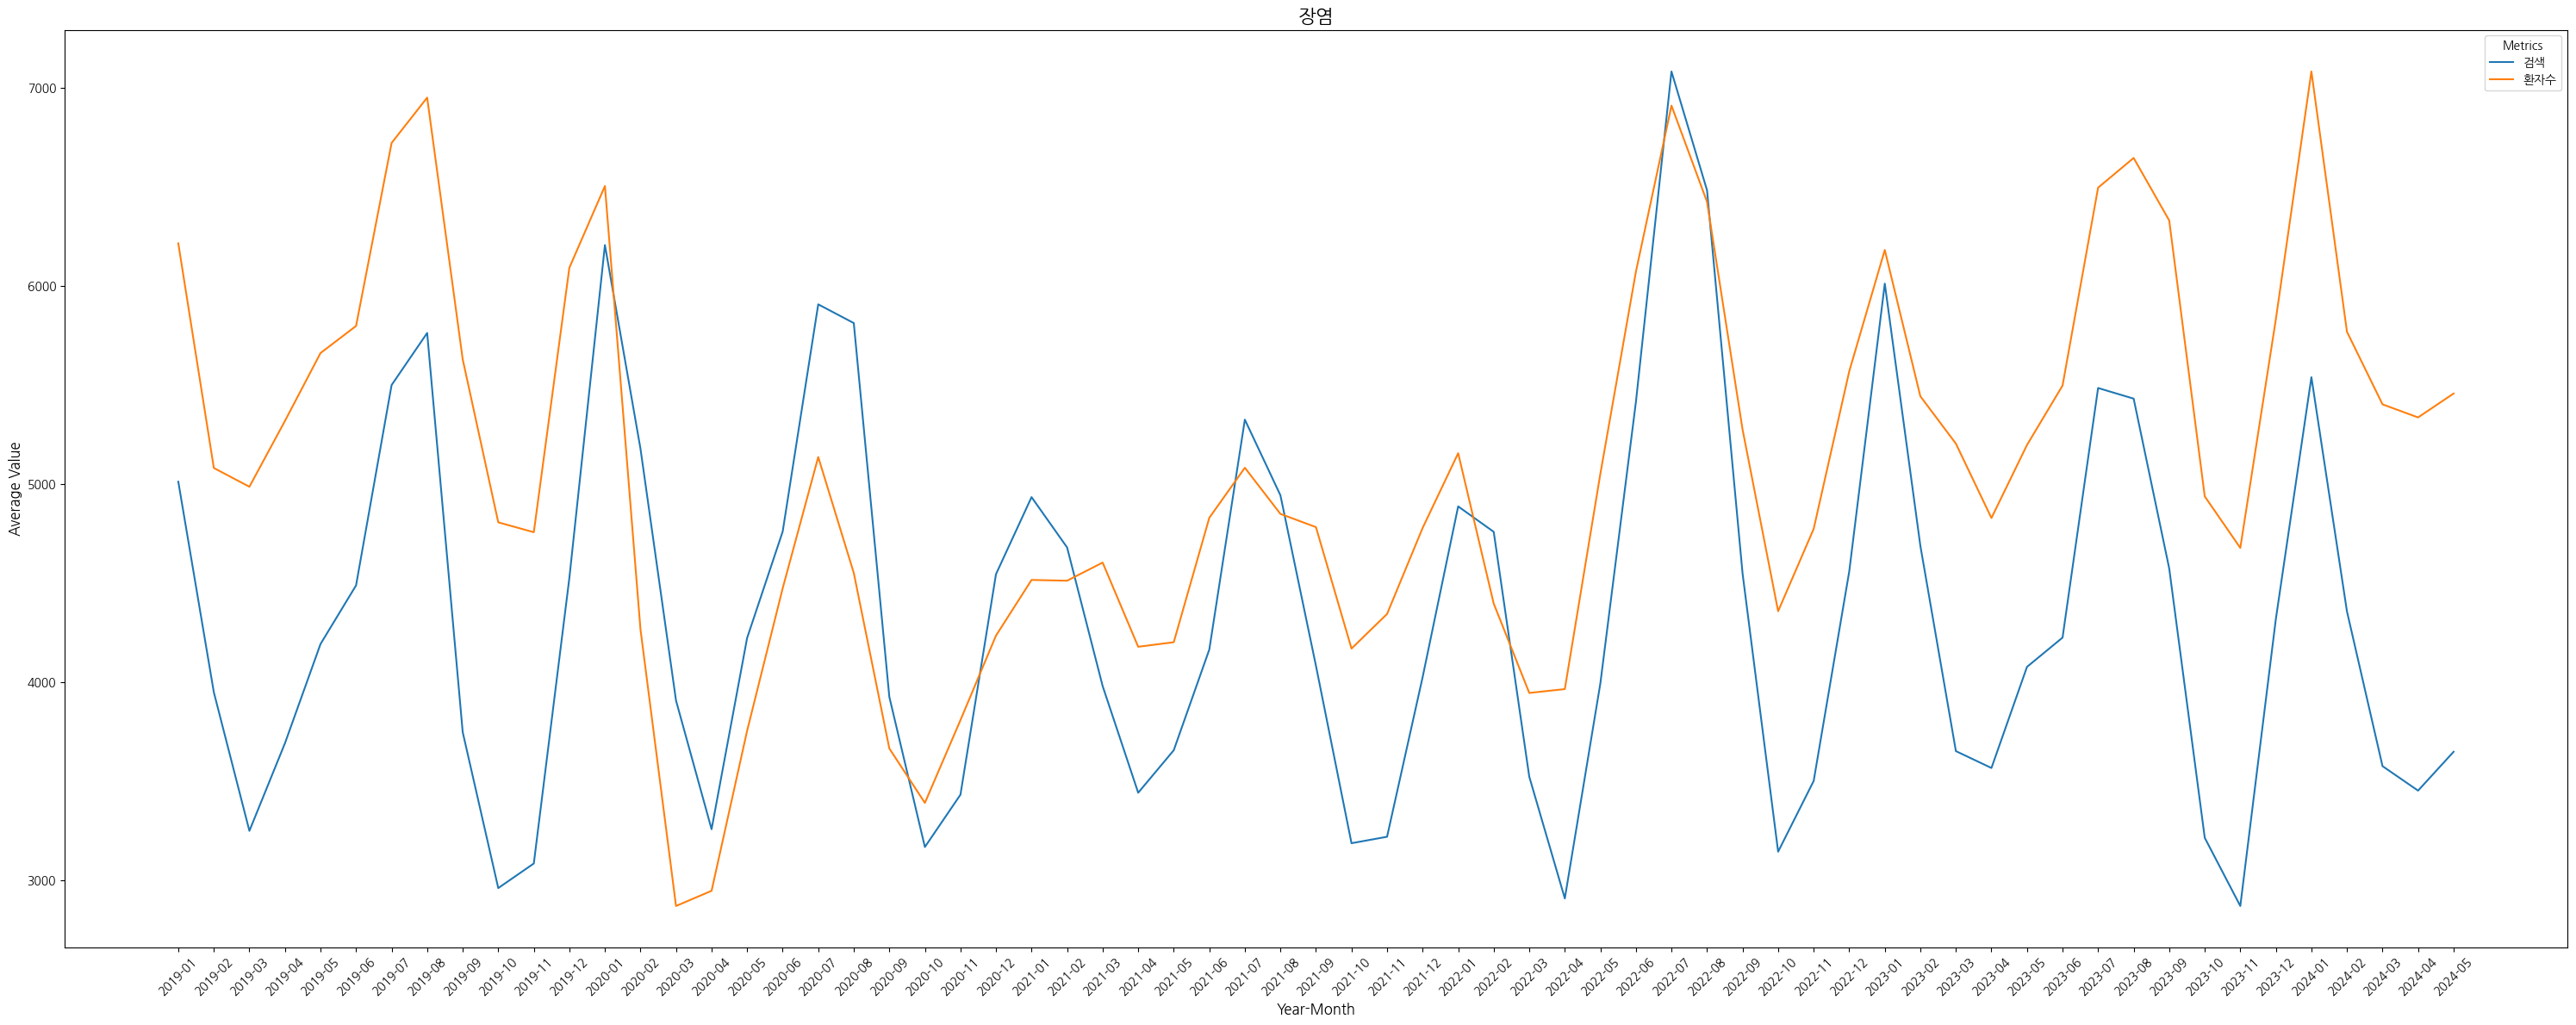

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

plt.figure(figsize=(30, 12))
plt.plot(ndf.index.astype(str), ndf["gastroenteritis"], label=("검색"))
plt.plot(pdf.index.astype(str), pdf["patient_count"], label=("환자수"))

plt.title("장염", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.legend(title="Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [266]:
ndf = ndf.reset_index()
pdf

,report_date,patient_count
0,2019-01,6213.83
1,2019-02,5080.37
2,2019-03,4985.79
3,2019-04,5317.83
4,2019-05,5660.35
...,...,...
60,2024-01,7081.31
61,2024-02,5767.83
62,2024-03,5401.57
63,2024-04,5335.56


In [265]:
# year_monthly_average
pdf

,report_date,patient_count
0,2019-01,6213.83
1,2019-02,5080.37
2,2019-03,4985.79
3,2019-04,5317.83
4,2019-05,5660.35
...,...,...
60,2024-01,7081.31
61,2024-02,5767.83
62,2024-03,5401.57
63,2024-04,5335.56


In [273]:
pdf['report_date'] = pd.to_datetime(pdf['report_date']).dt.to_period('M')

merged_df = pd.merge(ndf, pdf, left_on='report_date', right_on='report_date', how='inner')


# 결측값 제거
merged_df = merged_df.dropna()

# 확인
print(merged_df.head())

  report_date  gastroenteritis  patient_count
0     2019-01      5011.172414        6213.83
1     2019-02      3948.239646        5080.37
2     2019-03      3249.204195        4985.79
3     2019-04      3691.409118        5317.83
4     2019-05      4192.008019        5660.35


  report_date  gastroenteritis  patient_count
0     2019-01      5011.172414        6213.83
1     2019-02      3948.239646        5080.37
2     2019-03      3249.204195        4985.79
3     2019-04      3691.409118        5317.83
4     2019-05      4192.008019        5660.35
                 gastroenteritis  patient_count
gastroenteritis          1.00000        0.62863
patient_count            0.62863        1.00000


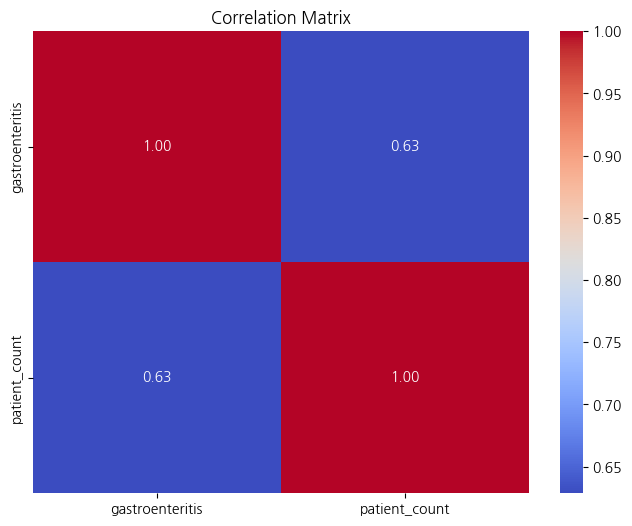

In [274]:
# 두 데이터 병합 (기준: report_date)
merged_df = pd.merge(ndf, pdf, left_on='report_date', right_on='report_date', how='inner')

# 결측값 제거
merged_df = merged_df.dropna()

# 확인
print(merged_df.head())

# 상관 행렬 계산
correlation_matrix = merged_df[['gastroenteritis', 'patient_count']].corr()

# 상관 행렬 출력
print(correlation_matrix)

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [212]:
# 열 이름 확인
print(year_monthly_average.columns)  # ['index', 'value1']
print(df.columns)  # ['index', 'value2']

# 병합
merged_df = pd.merge(year_monthly_average, df, on='index', how='inner')

# 결과 확인
print(merged_df)

Index(['gastroenteritis'], dtype='object')
Index(['patient_count'], dtype='object')


KeyError: 'index'

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 2019-01 to 2024-05
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_count  65 non-null     float64
dtypes: float64(1)
memory usage: 1.0+ KB


In [180]:
# 인덱스를 열로 변환
year_monthly_average.reset_index(inplace=True)
df.reset_index(inplace=True)

# 열 이름 확인
print(year_monthly_average.columns)  # ['index', 'value1']
print(df.columns)  # ['index', 'value2']

# 병합
merged_df = pd.merge(year_monthly_average, df, on='index', how='inner')

# 결과 확인
print(merged_df)

Index(['year_month', 'allergy', 'shingles', 'hfmd', 'gastroenteritis',
       'food_poisoning', 'cold', 'flu', 'cold_injury'],
      dtype='object')
Index(['report_date', 'patient_count'], dtype='object')


KeyError: 'index'